## Import Library

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
# from imblearn.pipeline import Pipeline as ImbPipeline

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/#KaburAjaDulu/hasil_sentimen")
df.head()

,full_text,clean_text,tokens,stopword,remove_slang,stemming,stemming_sentence,translated_en,sentiment,polarity_score,label
0,Udah ngerasain #KaburAjaDulu trus balik bentar...,udah ngerasain kaburajadulu trus balik bentar ...,"['udah', 'ngerasain', 'kaburajadulu', 'trus', ...","['ngerasain', 'kaburajadulu', 'trus', 'bentar'...","['kaburajadulu', 'bentar', 'bersyukur', 'sekar...","['kaburajadulu', 'bentar', 'syukur', 'sekarat'...",kaburajadulu bentar syukur sekarat ujung wafat...,kaburajadulu wait a minute dying the end of th...,negatif,-0.5,0
1,https://t.co/mC0g1FJSgk Sambil grinding buat p...,sambil grinding buat persiapan kaburajadulu al...,"['sambil', 'grinding', 'buat', 'persiapan', 'k...","['grinding', 'persiapan', 'kaburajadulu', 'all...","['grinding', 'persiapan', 'kaburajadulu', 'all...","['grinding', 'siap', 'kaburajadulu', 'all', 't...",grinding siap kaburajadulu all the best for al...,grinding siap kaburajadulu all the best for al...,positif,1.0,2
2,Apakah di sini ada yang butuh info apply visa ...,apakah di sini ada yang butuh info apply visa ...,"['apakah', 'di', 'sini', 'ada', 'yang', 'butuh...","['butuh', 'info', 'apply', 'visa', 'kaburajadu...","['butuh', 'info', 'apply', 'visa', 'kaburajadu...","['butuh', 'info', 'apply', 'visa', 'kaburajadu...",butuh info apply visa kaburajadulu kanada us e...,need info apply visa kaburajadulu canada us eu...,netral,0.0,1
3,@twisterfruity Search hashtag #kaburajadulu,search hashtag kaburajadulu,"['search', 'hashtag', 'kaburajadulu']","['search', 'hashtag', 'kaburajadulu']","['search', 'hashtag', 'kaburajadulu']","['search', 'hashtag', 'kaburajadulu']",search hashtag kaburajadulu,search hashtag kaburajadulu,netral,0.0,1
4,@cattominyg @tanyakanrl biar bisa make hastag ...,biar bisa make hastag kaburajadulu,"['biar', 'bisa', 'make', 'hastag', 'kaburajadu...","['make', 'hastag', 'kaburajadulu']","['hastag', 'kaburajadulu']","['hastag', 'kaburajadulu']",hastag kaburajadulu,hastag kaburajadulu,netral,0.0,1


In [6]:
# df.to_csv("/content/drive/MyDrive/Colab Notebooks/#KaburAjaDulu/hasil_akhir.csv", index=False, encoding="utf-8-sig")

In [7]:
df['stemming_sentence'] = df['stemming_sentence'].fillna('')
df['stemming_sentence'] = df['stemming_sentence'].astype(str)

X = df['stemming_sentence']
y = df['label']

##Feature Extraction (TF-IDF)

In [8]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

tfidf_array = X_tfidf.toarray()
feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_array, columns=feature_names)

tfidf_sum = tfidf_df.sum(axis=0).reset_index()
tfidf_sum.columns = ['Kata', 'Skor TF-IDF']

tfidf_sum = tfidf_sum.sort_values(by='Skor TF-IDF', ascending=False)

tfidf_sum.head(10)

,Kata,Skor TF-IDF
4004,kaburajadulu,670.163885
5683,negara,79.726027
3520,indonesia,63.879072
4000,kabur,56.108862
3858,jepang,47.281579
3526,indonesiagelap,43.254583
3446,ikut,41.755205
5692,negeri,38.598173
8526,the,35.991903
5266,mending,30.375488


## Penerapan K-Fold Cross Validation

In [9]:
models = {
    'SVM_Linear': SVC(kernel='linear', class_weight='balanced', random_state=42),
    'SVM_Polynomial': SVC(kernel='poly', class_weight='balanced', random_state=42),
    'SVM_Sigmoid': SVC(kernel='sigmoid', class_weight='balanced', random_state=42)
}

splits = [
    (0.2, '80:20'),
    (0.3, '70:30'),
    (0.4, '60:40')
]

results = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"\nEvaluating model: {model_name}")

    for test_size, split_label in splits:
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=test_size, random_state=42, stratify=y)

        # Terapkan SMOTE hanya pada data latih
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Latih dan prediksi
        model.fit(X_train_resampled, y_train_resampled)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        # Cross-validation dengan pipeline & StratifiedKFold
        pipeline = Pipeline([
            ('smote', SMOTE(random_state=42)),
            ('model', model)
        ])
        cv_score = cross_val_score(pipeline, X_tfidf, y, cv=kf, scoring='f1_weighted', n_jobs=-1)
        cv_mean = cv_score.mean()

        results.append({
            'Model': model_name,
            'Split': split_label,
            'Accuracy': acc,
            'CV Mean Accuracy': cv_mean,
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-score': report['weighted avg']['f1-score']
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1-score', ascending=False).reset_index(drop=True)

print("\n📊 ==== HASIL EVALUASI MODEL SVM ====\n")

for model_name in results_df['Model'].unique():
    print(f"🔍 Evaluating Model: {model_name}\n")
    model_results = results_df[results_df['Model'] == model_name]

    for idx, row in model_results.iterrows():
        print(f"➡️  Split: {row['Split']}")
        print(f"   - Accuracy        : {row['Accuracy']:.4f}")
        print(f"   - CV Mean Accuracy: {row['CV Mean Accuracy']:.4f}")
        print(f"   - Precision       : {row['Precision']:.4f}")
        print(f"   - Recall          : {row['Recall']:.4f}")
        print(f"   - F1-score        : {row['F1-score']:.4f}\n")

print("🏆 Top 5 Hasil Tertinggi Berdasarkan F1-score:")
print(results_df.head())


Evaluating model: SVM_Linear

Evaluating model: SVM_Polynomial

Evaluating model: SVM_Sigmoid

📊 ==== HASIL EVALUASI MODEL SVM ====

🔍 Evaluating Model: SVM_Sigmoid

➡️  Split: 80:20
   - Accuracy        : 0.7804
   - CV Mean Accuracy: 0.7639
   - Precision       : 0.7778
   - Recall          : 0.7804
   - F1-score        : 0.7789

➡️  Split: 70:30
   - Accuracy        : 0.7652
   - CV Mean Accuracy: 0.7639
   - Precision       : 0.7620
   - Recall          : 0.7652
   - F1-score        : 0.7633

➡️  Split: 60:40
   - Accuracy        : 0.7569
   - CV Mean Accuracy: 0.7639
   - Precision       : 0.7528
   - Recall          : 0.7569
   - F1-score        : 0.7545

🔍 Evaluating Model: SVM_Linear

➡️  Split: 80:20
   - Accuracy        : 0.7815
   - CV Mean Accuracy: 0.7728
   - Precision       : 0.7766
   - Recall          : 0.7815
   - F1-score        : 0.7784

➡️  Split: 70:30
   - Accuracy        : 0.7667
   - CV Mean Accuracy: 0.7728
   - Precision       : 0.7594
   - Recall          :

In [10]:
# splittig data 80:20
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

## SMOTE

In [14]:
# SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [15]:
print("Sebelum SMOTE:", Counter(y_train))
print("Setelah SMOTE:", Counter(y_train_smote))

Sebelum SMOTE: Counter({1: 2258, 2: 917, 0: 502})
Setelah SMOTE: Counter({1: 2258, 0: 2258, 2: 2258})


/tmp/ipython-input-1105785742.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot1 = sns.countplot(x=y_train, ax=axs[0], palette=palette)
/tmp/ipython-input-1105785742.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(["Negatif", "Netral", "Positif"], fontsize=14)
/tmp/ipython-input-1105785742.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot2 = sns.countplot(x=y_train_smote, ax=axs[1], palette=palette)
/tmp/ipython-input-1105785742.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(["N

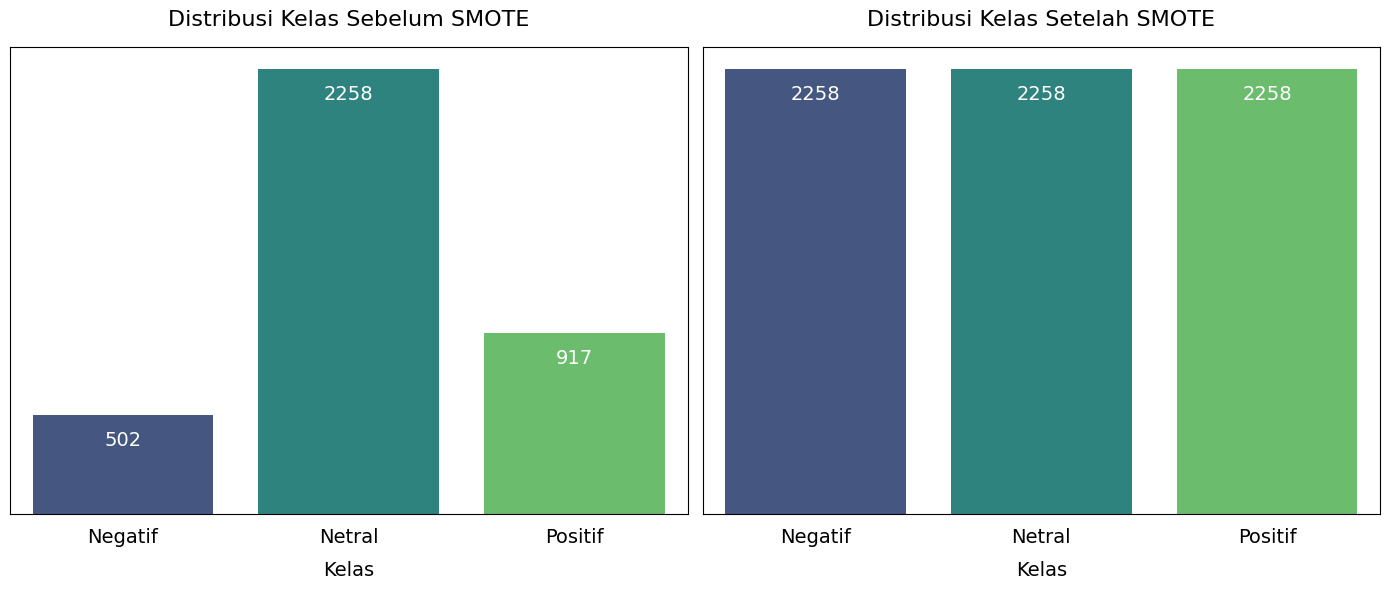

In [17]:
palette = sns.color_palette("viridis", 3)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# sebelum SMOTE
plot1 = sns.countplot(x=y_train, ax=axs[0], palette=palette)
axs[0].set_title("Distribusi Kelas Sebelum SMOTE", pad=15, fontsize=16)
axs[0].set_xlabel("Kelas", labelpad=10, fontsize=14)
axs[0].set_ylabel("")
axs[0].set_xticklabels(["Negatif", "Netral", "Positif"], fontsize=14)
axs[0].set_yticks([])
axs[0].tick_params(axis='both', length=0, pad=10)

for container in plot1.containers:
    axs[0].bar_label(container, label_type='edge', padding=-25, color="white", fontsize=14)

# setelah SMOTE
plot2 = sns.countplot(x=y_train_smote, ax=axs[1], palette=palette)
axs[1].set_title("Distribusi Kelas Setelah SMOTE", pad=15, fontsize=16)
axs[1].set_xlabel("Kelas", labelpad=10, fontsize=14)
axs[1].set_ylabel("")
axs[1].set_xticklabels(["Negatif", "Netral", "Positif"], fontsize=14)
axs[1].set_yticks([])
axs[1].tick_params(axis='both', length=0, pad=10)

for container in plot2.containers:
    axs[1].bar_label(container, label_type='edge', padding=-25, color="white", fontsize=14)

plt.tight_layout()
plt.show()

##Hyperparameter Tunning GridSearch

In [24]:
C_values = [0.1, 1, 10, 100]
gamma_values = ["scale", "auto"]
degree_values = [2, 3, 4]

models_with_params = {
    "Linear": (
        SVC(kernel="linear", class_weight="balanced", random_state=42),
        {"C": C_values}
    ),
    "Sigmoid": (
        SVC(kernel="sigmoid", class_weight="balanced", random_state=42),
        {"C": C_values, "gamma": gamma_values}
    ),
    "Polynomial": (
        SVC(kernel="poly", class_weight="balanced", random_state=42),
        {"C": C_values, "degree": degree_values, "gamma": gamma_values}
    ),
}

performance_results = []
best_models = {}

for name, (model, params) in models_with_params.items():
    print(f"\n🔍 Tuning SVM_{name} ...")

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_smote, y_train_smote)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model

    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro")
    rec = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    print(f"✅ Best Params: {grid_search.best_params_}")
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))

    performance_results.append({
        "Model": f"SVM_{name}",
        "Accuracy": acc * 100,
        "Precision": prec * 100,
        "Recall": rec * 100,
        "F1-score": f1 * 100,
    })


🔍 Tuning SVM_Linear ...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
✅ Best Params: {'C': 10}
✅ Accuracy: 0.7598
              precision    recall  f1-score   support

           0     0.6273    0.5520    0.5872       125
           1     0.8198    0.8779    0.8479       565
           2     0.6537    0.5826    0.6161       230

    accuracy                         0.7598       920
   macro avg     0.7003    0.6708    0.6837       920
weighted avg     0.7521    0.7598    0.7545       920


🔍 Tuning SVM_Sigmoid ...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Best Params: {'C': 1, 'gamma': 'scale'}
✅ Accuracy: 0.7804
              precision    recall  f1-score   support

           0     0.6341    0.6240    0.6290       125
           1     0.8529    0.8726    0.8626       565
           2     0.6712    0.6391    0.6548       230

    accuracy                         0.7804       920
   macro avg     0.7194    0.7119    0.7155       920
weighted avg     

,Model,Accuracy,Precision,Recall,F1-score
0,SVM_Linear,75.978261,70.025532,67.082827,68.372975
1,SVM_Sigmoid,78.043478,71.944013,71.189894,71.548762
2,SVM_Polynomial,71.086957,71.757704,52.999051,56.514694


In [25]:
# model SVM kernel linear
svm_linear = SVC(kernel='linear', C=10, class_weight="balanced", random_state=42)
svm_linear.fit(X_train_smote, y_train_smote)
y_pred_linear = svm_linear.predict(X_test)

acc = accuracy_score(y_test, y_pred_linear) * 100
prec = precision_score(y_test, y_pred_linear, average='macro', zero_division=0) * 100
rec = recall_score(y_test, y_pred_linear, average='macro', zero_division=0) * 100
f1 = f1_score(y_test, y_pred_linear, average='macro', zero_division=0) * 100

print("Hasil Evaluasi SVM Kernel Linear:")
print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")

Hasil Evaluasi SVM Kernel Linear:
Akurasi  : 75.9783
Presisi  : 70.0255
Recall   : 67.0828
F1-Score : 68.3730


In [26]:
# model SVM kernel sigmoid
svm_sig = SVC(kernel='sigmoid', C=1, gamma='scale', class_weight="balanced", random_state=42)
svm_sig.fit(X_train_smote, y_train_smote)
y_pred_sig = svm_sig.predict(X_test)

acc_sig = accuracy_score(y_test, y_pred_sig) * 100
prec_sig = precision_score(y_test, y_pred_sig, average='macro', zero_division=0) * 100
rec_sig = recall_score(y_test, y_pred_sig, average='macro', zero_division=0) * 100
f1_sig = f1_score(y_test, y_pred_sig, average='macro', zero_division=0) * 100

print("Hasil Evaluasi SVM Kernel Sigmoid:")
print(f"Akurasi  : {acc_sig:.4f}")
print(f"Presisi  : {prec_sig:.4f}")
print(f"Recall   : {rec_sig:.4f}")
print(f"F1-Score : {f1_sig:.4f}")

Hasil Evaluasi SVM Kernel Sigmoid:
Akurasi  : 78.0435
Presisi  : 71.9440
Recall   : 71.1899
F1-Score : 71.5488


In [28]:
# model SVM kernel polynomial
svm_poly = SVC(kernel='poly', C=1, gamma='scale', degree=2, class_weight="balanced", random_state=42)
svm_poly.fit(X_train_smote, y_train_smote)
y_pred_poly = svm_poly.predict(X_test)

acc_poly = accuracy_score(y_test, y_pred_poly) * 100
prec_poly = precision_score(y_test, y_pred_poly, average='macro', zero_division=0) * 100
rec_poly = recall_score(y_test, y_pred_poly, average='macro', zero_division=0) * 100
f1_poly = f1_score(y_test, y_pred_poly, average='macro', zero_division=0) * 100

print("Hasil Evaluasi SVM Kernel Polynomial:")
print(f"Akurasi  : {acc_poly:.4f}")
print(f"Presisi  : {prec_poly:.4f}")
print(f"Recall   : {rec_poly:.4f}")
print(f"F1-Score : {f1_poly:.4f}")

Hasil Evaluasi SVM Kernel Polynomial:
Akurasi  : 71.0870
Presisi  : 71.7577
Recall   : 52.9991
F1-Score : 56.5147


In [34]:
model_names = ['SVM Kernel Linear', 'SVM Kernel Sigmoid', 'SVM Kernel Polynomial']
predictions = [y_pred_linear, y_pred_sig, y_pred_poly]

results = []

for name, y_pred in zip(model_names, predictions):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    results.append({
        'Model': name,
        'Akurasi': round(acc, 6),
        'Presisi': round(prec, 6),
        'Recall': round(rec, 6),
        'F1-Score': round(f1, 6)
    })

df_hasil_klasifikasi = pd.DataFrame(results)
print(df_hasil_klasifikasi)

                   Model   Akurasi   Presisi    Recall  F1-Score
0      SVM Kernel Linear  0.759783  0.700255  0.670828  0.683730
1     SVM Kernel Sigmoid  0.780435  0.719440  0.711899  0.715488
2  SVM Kernel Polynomial  0.710870  0.717577  0.529991  0.565147


## Evaluasi Model

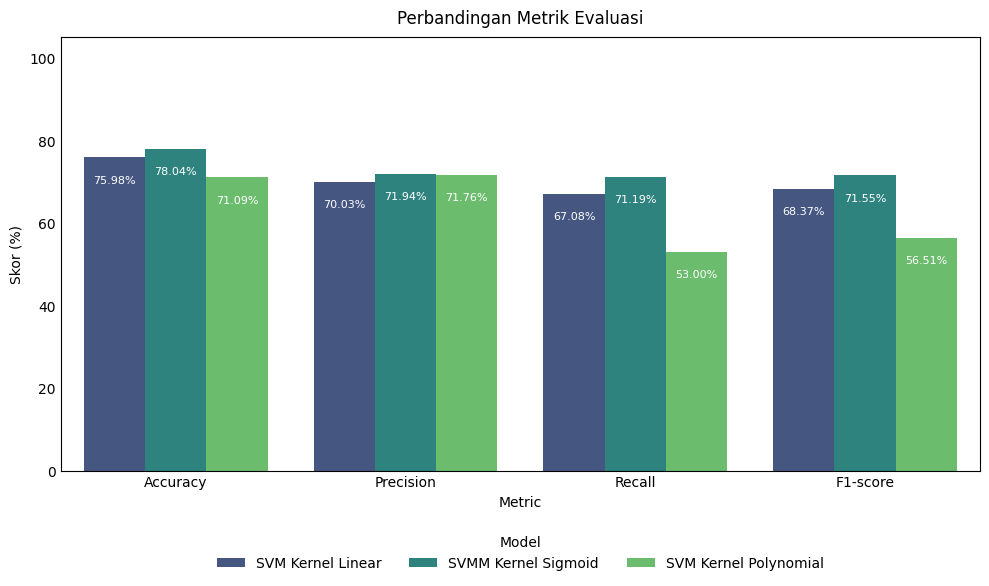

In [31]:
def evaluate_model(y_true, y_pred, label):
    return {
        'Model': label,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1-score': f1_score(y_true, y_pred, average='macro', zero_division=0)
    }

result_model = []
result_model.append(evaluate_model(y_test, y_pred_linear, "SVM Kernel Linear"))
result_model.append(evaluate_model(y_test, y_pred_sig, "SVMM Kernel Sigmoid"))
result_model.append(evaluate_model(y_test, y_pred_poly, "SVM Kernel Polynomial"))

df_compare = pd.DataFrame(result_model)
df_melt = df_compare.melt(id_vars='Model', var_name='Metric', value_name='Score')
df_melt['Score'] = df_melt['Score'] * 100

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_melt, x='Metric', y='Score', hue='Model', palette='viridis')
ax.tick_params(axis='both', length=0)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='edge', color='white', fontsize=8, padding=-20)

plt.title('Perbandingan Metrik Evaluasi', pad=10)
plt.ylabel('Skor (%)')
plt.ylim(0, 105)
plt.legend(title='Model', loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)
plt.tight_layout()
plt.show()

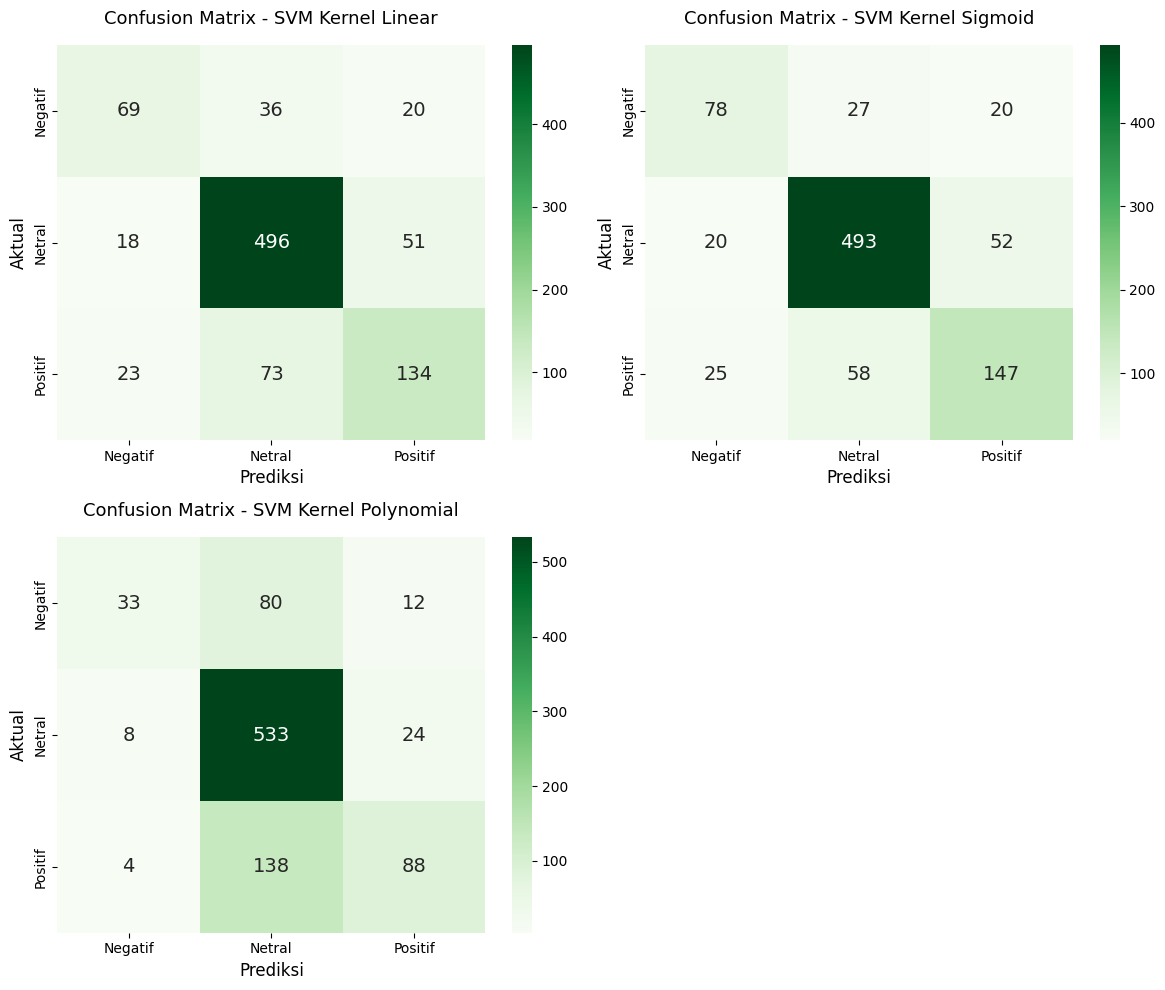

In [39]:
matrix_linear = confusion_matrix(y_test, y_pred_linear)
matrix_sig = confusion_matrix(y_test, y_pred_sig)
matrix_poly = confusion_matrix(y_test, y_pred_poly)

labels = ['Negatif', 'Netral', 'Positif']

df_cm_linear = pd.DataFrame(matrix_linear, index=labels, columns=labels)
df_cm_sig = pd.DataFrame(matrix_sig, index=labels, columns=labels)
df_cm_poly = pd.DataFrame(matrix_poly, index=labels, columns=labels)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.heatmap(df_cm_linear, annot=True, cmap="Greens", fmt='g', ax=axes[0,0], annot_kws={"fontsize":14})
axes[0,0].set_title("Confusion Matrix - SVM Kernel Linear", pad=15, fontsize=13)
axes[0,0].set_xlabel("Prediksi", fontsize=12)
axes[0,0].set_ylabel("Aktual", fontsize=12)

sns.heatmap(df_cm_sig, annot=True, cmap="Greens", fmt='g', ax=axes[0,1], annot_kws={"fontsize":14})
axes[0,1].set_title("Confusion Matrix - SVM Kernel Sigmoid", pad=15, fontsize=13)
axes[0,1].set_xlabel("Prediksi", fontsize=12)
axes[0,1].set_ylabel("Aktual", fontsize=12)

sns.heatmap(df_cm_poly, annot=True, cmap="Greens", fmt='g', ax=axes[1,0], annot_kws={"fontsize":14})
axes[1,0].set_title("Confusion Matrix - SVM Kernel Polynomial", pad=15, fontsize=13)
axes[1,0].set_xlabel("Prediksi", fontsize=12)
axes[1,0].set_ylabel("Aktual", fontsize=12)

fig.delaxes(axes[1,1])

plt.tight_layout()
plt.show()

## Deployment Model

In [40]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 136.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.0 MB/s eta 0:00:00


In [41]:
import joblib
import os
import streamlit as st
import pandas as pd
from pyngrok import ngrok

In [45]:
# y_pred_linear = svm_linear.predict(X_test)
# linear_report = classification_report(y_test, y_pred_linear, output_dict=True)

# joblib.dump({
#     'model': svm_linear,
#     'vectorizer': vectorizer,
#     'classification_report': linear_report,
#     'y_true': y_test,
#     'y_pred': y_pred_linear,
#     'note': 'Model SVM Kernel Linear'
# }, 'svm_linear.joblib_fix')

['svm_linear.joblib_fix']

In [46]:
# y_pred_sig = svm_sig.predict(X_test)
# svm_sig_report = classification_report(y_test, y_pred_sig, output_dict=True)

# joblib.dump({
#     'model': svm_sig,
#     'vectorizer': vectorizer,
#     'classification_report': svm_sig_report,
#     'y_true': y_test,
#     'y_pred': y_pred_sig,
#     'note': 'Model SVM Kernel Sigmoid'
# }, 'svm_sig.joblib_fix')

['svm_sig.joblib_fix']

In [47]:
# y_pred_poly = svm_poly.predict(X_test)
# svm_poly_report = classification_report(y_test, y_pred_poly, output_dict=True)

# joblib.dump({
#     'model': svm_poly,
#     'vectorizer': vectorizer,
#     'classification_report': svm_poly_report,
#     'y_true': y_test,
#     'y_pred': y_pred_poly,
#     'note': 'Model SVM Kernel Polynomial'
# }, 'svm_poly.joblib_fix')

['svm_poly.joblib_fix']

In [54]:
svm_linear = "/content/drive/MyDrive/Colab Notebooks/#KaburAjaDulu/svm_linear.joblib_fix"
svm_sig = "/content/drive/MyDrive/Colab Notebooks/#KaburAjaDulu/svm_sig.joblib_fix"
svm_poly = "/content/drive/MyDrive/Colab Notebooks/#KaburAjaDulu/svm_poly.joblib_fix"

In [55]:
%%writefile app.py

Overwriting app.py


In [60]:
!ngrok config add-authtoken 2zbfWLMdonhy6DDSTOeaZSeN8o7_7fjAqrREYXHd56UoG6PpJ

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [61]:
ngrok.kill()

!streamlit run app.py &>/content/log.txt &
import time
time.sleep(3)
url = ngrok.connect("http://localhost:8501")
print(f"Aplikasi dapat diakses di URL: {url}")

Aplikasi dapat diakses di URL: NgrokTunnel: "https://2748bf07d93a.ngrok-free.app" -> "http://localhost:8501"
